c:\Users\Bayu Adhi Tama\.conda\envs\py-35\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TRI (Predicted): 17.0524
TRI (Reference): 14.2987
Relative Difference in TRI: 19.26%
Full Grid MAE (Original Scale): 12.4895
Full Grid RMSE (Original Scale): 19.3774
R² (Coefficient of Determination): 0.9872
SSIM (Structural Similarity Index): 0.9419
PSNR (Peak Signal-to-Noise Ratio): 36.2457 dB


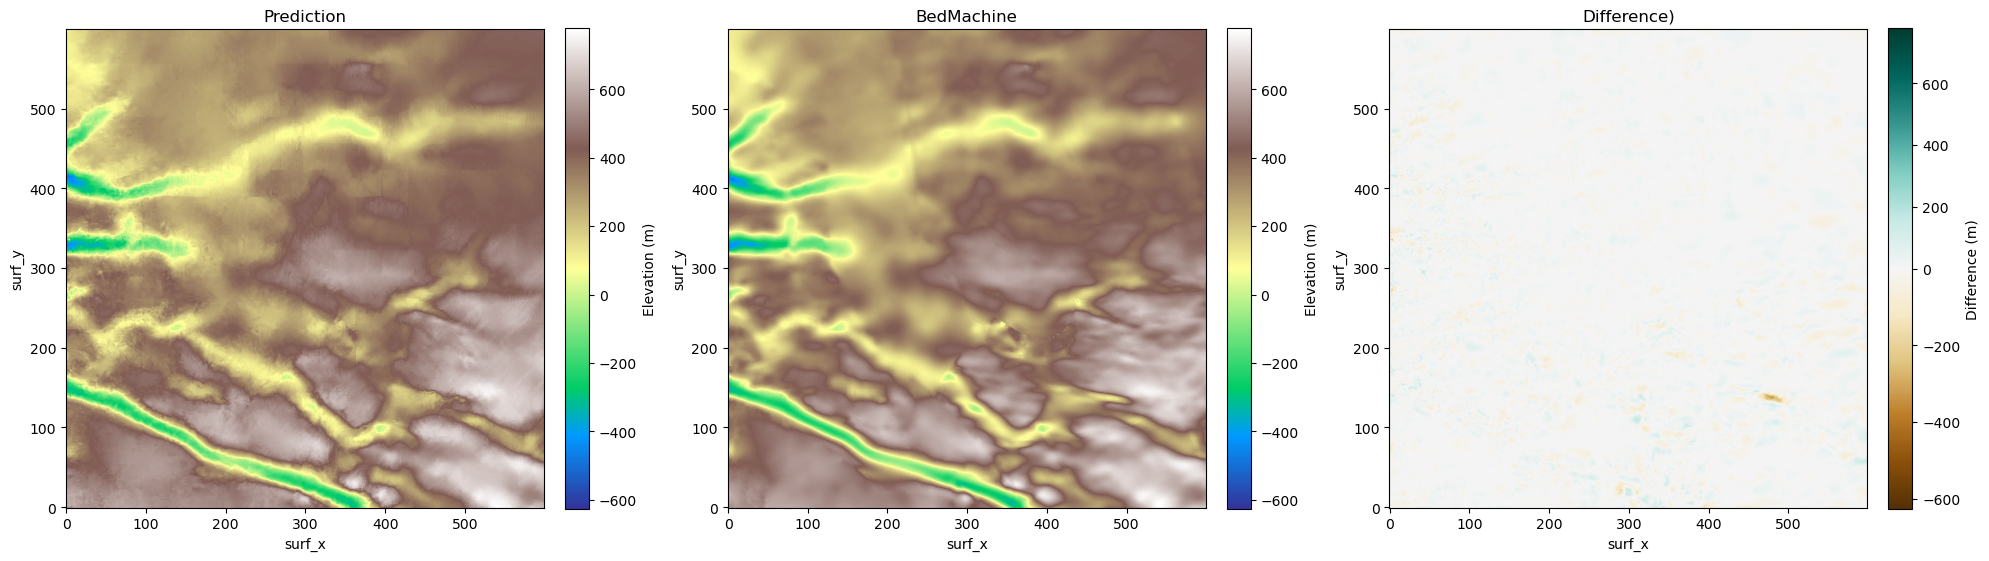

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import torch
from model import BedTopoCNN
import h5py
import numpy as np
import torch
from model import BedTopoCNN
from feature_augmentation import gradient_covariates, trend_surface
from dataset import BedTopoDataset
import pandas as pd
from compute_metrics import compute_metrics, calculate_TRI

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

variables = ['surf_SMB', 'surf_dhdt', 'surf_elv', 'surf_vx', 'surf_vy', 'surf_x', 'surf_y']    
data_dict = {}
with h5py.File('./data/hackathon.h5', 'r') as f:
    for var in variables:
        data_dict[var] = np.flipud(np.transpose(f[var][0:600, 600:1200])).copy()

# Stack the first 5 variables as input features
input_variables = ['surf_SMB', 'surf_dhdt', 'surf_elv', 'surf_vx', 'surf_vy']
inputs = np.stack([data_dict[var] for var in input_variables], axis=0)  # Shape: (5, 600, 600)
gradient_features = gradient_covariates(inputs)  # Gradient shape: (num_features * 2, height, width)
inputs = np.vstack([inputs, gradient_features])  # Concatenate gradients as additional features

trend_features = []
for i in range(inputs.shape[0]):  # Loop over all features
    trend = trend_surface(inputs[i])  # Compute trend surface for the feature
    trend_features.append(trend)

trend_features = np.vstack(trend_features)  # Combine all trend features
inputs = np.vstack([inputs, trend_features])  # Add trend features to inputs
mean_inputs = inputs.mean(axis=(1, 2), keepdims=True)
std_inputs = inputs.std(axis=(1, 2), keepdims=True)
inputs = (inputs - mean_inputs) / std_inputs

with h5py.File('./data/bed_BedMachine.h5', 'r') as file:
    bedmachine_data = np.flipud(np.transpose(file['bed_BedMachine'][0:600, 600:1200])).copy()
target_bed = bedmachine_data
mean_target = np.mean(target_bed)
std_target = np.std(target_bed)
target_bed = (target_bed - mean_target) / std_target

surf_x_min = np.min(np.abs(data_dict['surf_x']))
surf_y_min = np.min(np.abs(data_dict['surf_y']))    
radar_mask = np.zeros(target_bed.shape, dtype=bool)    
full_data_df = pd.read_csv('./data/data_full.csv')

for _, row in full_data_df.iterrows():        
    x_idx = int(600 - np.round((np.abs(row['surf_x']) - surf_x_min) / 150) - 1)
    y_idx = int(np.round((np.abs(row['surf_y']) - surf_y_min) / 150))
    if 0 <= x_idx < 600 and 0 <= y_idx < 600:
        radar_mask[x_idx, y_idx] = True

radar_mask_tensor = torch.tensor(radar_mask, dtype=torch.bool)

dataset = BedTopoDataset(inputs, target_bed, radar_mask_tensor, patch_size=16, stride=8)
model = BedTopoCNN(in_channels=inputs.shape[0]).to(device)


val_loss_radar = []
val_loss_bedmachine = []

# Full Grid Prediction
checkpoint = torch.load('./saved_models/best_model_16_stride_8.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()
with torch.no_grad():
    # Reshape inputs for the full grid
    full_inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 5, 600, 600)
    full_target = torch.tensor(target_bed, dtype=torch.float32).to(device)  # Shape: (600, 600)
    radar_mask = radar_mask_tensor.to(device)  # Shape: (600, 600)

    # Predict the full grid
    full_predictions = model(full_inputs).squeeze(0).squeeze(0)      
    full_predictions_unnormalized = (full_predictions * std_target) + mean_target
    full_target_unnormalized = (full_target * std_target) + mean_target    
    mae, rmse, r2, ssim_value, psnr_value = compute_metrics(full_predictions_unnormalized, full_target_unnormalized)    
    tri_predicted = calculate_TRI(full_predictions_unnormalized)
    tri_reference = calculate_TRI(full_target_unnormalized)
    
    tri_relative_difference = (abs(tri_predicted - tri_reference) / tri_reference) * 100
    print(f"TRI (Predicted): {tri_predicted:.4f}")
    print(f"TRI (Reference): {tri_reference:.4f}")
    print(f"Relative Difference in TRI: {tri_relative_difference:.2f}%")
    print(f"Full Grid MAE (Original Scale): {mae:.4f}")
    print(f"Full Grid RMSE (Original Scale): {rmse:.4f}")
    print(f"R² (Coefficient of Determination): {r2:.4f}")
    print(f"SSIM (Structural Similarity Index): {ssim_value:.4f}")
    print(f"PSNR (Peak Signal-to-Noise Ratio): {psnr_value:.4f} dB")

difference = full_target_unnormalized - full_predictions_unnormalized  

min_value = -626.96027
max_value = 778.96765

plt.figure(figsize=(20, 6))  
# Predicted Bed Topography (Original Scale)
plt.subplot(1, 3, 1)
plt.title("Prediction")
plt.imshow(full_predictions_unnormalized.cpu().numpy(), cmap='terrain', vmin=min_value, vmax=max_value,origin='lower')
plt.colorbar(label='Elevation (m)',fraction=0.046, pad=0.04)
plt.xlabel("surf_x")
plt.ylabel("surf_y")

# Ground Truth Bed Topography (Original Scale)
plt.subplot(1, 3, 2)
plt.title("BedMachine")
plt.imshow(full_target_unnormalized.cpu().numpy(), cmap='terrain',vmin=min_value, vmax=max_value, origin='lower')
plt.colorbar(label='Elevation (m)',fraction=0.046, pad=0.04)
plt.xlabel("surf_x")
plt.ylabel("surf_y")

# Difference (Ground Truth - Prediction)
plt.subplot(1, 3, 3)
plt.title("Difference)")
norm = TwoSlopeNorm(vmin=min_value, vcenter=0, vmax=max_value)
plt.imshow(difference.cpu().numpy(), cmap='BrBG', norm=norm, origin='lower')
plt.colorbar(label='Difference (m)',fraction=0.046, pad=0.04)
plt.xlabel("surf_x")
plt.ylabel("surf_y")

plt.tight_layout()
